<a href="https://colab.research.google.com/github/LuBly/Knowledge_Distillation/blob/main/KD_using_CNN_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번 주차에는 위와 같은 과정을 적용시켜보고자 한다.

1. BaseLine CNN 2 Layer 
2. Teacher model CNN 10 Layer
3. DataSet:cifar10


# **필요한 라이브러리를 import**

import Library For Create CNN Layer model, Data Load

In [26]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as torch_models
import torch.nn.functional as F
import torch.optim as optim

Import Library For Training

In [27]:
import os
import copy
import time

Import Library For Display Chart

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

Data Load

In [29]:
dataset_dir='./data'
batch_size=128
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
simple_transform = transforms.Compose([transforms.ToTensor(), normalize])

train_transform = simple_transform

trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True,
download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False,
download=True, transform=simple_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
pin_memory=True, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
pin_memory=True, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Teacher, Student Layer model 생성

In [30]:
class ConvNetMaker(nn.Module):
	"""
	Creates a simple (plane) convolutional neural network
	"""
	def __init__(self, layers):
		"""
		Makes a cnn using the provided list of layers specification
		The details of this list is available in the paper
		:param layers: a list of strings, representing layers like ["CB32", "CB32", "FC10"]
		"""
		super(ConvNetMaker, self).__init__()
		self.conv_layers = []
		self.fc_layers = []
		h, w, d = 32, 32, 3
		previous_layer_filter_count = 3
		previous_layer_size = h * w * d
		num_fc_layers_remained = len([1 for l in layers if l.startswith('FC')])
		for layer in layers:
			if layer.startswith('Conv'):
				filter_count = int(layer[4:])
				self.conv_layers += [nn.Conv2d(previous_layer_filter_count, filter_count, kernel_size=3, padding=1),
									 nn.BatchNorm2d(filter_count), nn.ReLU(inplace=True)]
				previous_layer_filter_count = filter_count
				d = filter_count
				previous_layer_size = h * w * d
			elif layer.startswith('MaxPool'):
				self.conv_layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
				h, w = int(h / 2.0), int(w / 2.0)
				previous_layer_size = h * w * d
			elif layer.startswith('FC'):
				num_fc_layers_remained -= 1
				current_layer_size = int(layer[2:])
				if num_fc_layers_remained == 0:
					self.fc_layers += [nn.Linear(previous_layer_size, current_layer_size)]
				else:
					self.fc_layers += [nn.Linear(previous_layer_size, current_layer_size), nn.ReLU(inplace=True)]
				previous_layer_size = current_layer_size
		
		conv_layers = self.conv_layers
		fc_layers = self.fc_layers
		self.conv_layers = nn.Sequential(*conv_layers)
		self.fc_layers = nn.Sequential(*fc_layers)
	
	def forward(self, x):
		x = self.conv_layers(x)
		x = x.view(x.size(0), -1)
		x = self.fc_layers(x)
		return x



def plane2():
    return ConvNetMaker(['Conv16', 'MaxPool', 'Conv16', 'MaxPool', 'FC10'])
		
def plane10():
    return ConvNetMaker(['Conv32', 'Conv32', 'MaxPool', 'Conv64', 'Conv64', 'MaxPool', 'Conv128', 'Conv128', 'MaxPool',
		   'Conv256', 'Conv256', 'Conv256', 'Conv256' , 'MaxPool', 'FC128' ,'FC10'])


KD를 미적용한 Student Model의 학습_BaseLine

In [31]:
# check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = plane2().to(device)
x = torch.randn(3,3,32,32).to(device)
output = model(x)
print(output.shape)

torch.Size([3, 10])


가중치 초기화

In [32]:
# weight initialization
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [33]:
initialize_weights(model)

In [34]:
# loss function
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(model.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [35]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric    
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [36]:
# set hyper parameters
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'val_dl':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [37]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/19, current lr= 0.001
Copied best model weights!
train loss: 0.010872, val loss: 0.009533, accuracy: 56.86, time: 0.3340 min
----------
Epoch 1/19, current lr= 0.001
Copied best model weights!
train loss: 0.008635, val loss: 0.008421, accuracy: 62.80, time: 0.6643 min
----------
Epoch 2/19, current lr= 0.001
Copied best model weights!
train loss: 0.007941, val loss: 0.007996, accuracy: 64.93, time: 0.9910 min
----------
Epoch 3/19, current lr= 0.001
Copied best model weights!
train loss: 0.007526, val loss: 0.007928, accuracy: 65.31, time: 1.3240 min
----------
Epoch 4/19, current lr= 0.001
Copied best model weights!
train loss: 0.007234, val loss: 0.007826, accuracy: 65.70, time: 1.6547 min
----------
Epoch 5/19, current lr= 0.001
Copied best model weights!
train loss: 0.007017, val loss: 0.007815, accuracy: 65.50, time: 1.9929 min
----------
Epoch 6/19, current lr= 0.001
Copied best model weights!
train loss: 0.006845, val loss: 0.007692, accuracy: 65.88, time: 2.3288 min
---

Loss 와 Accuracy의 시각화

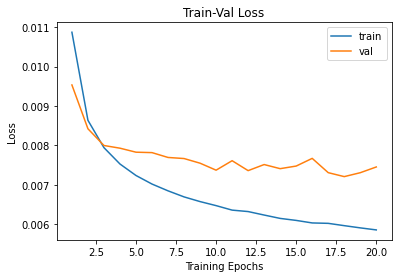

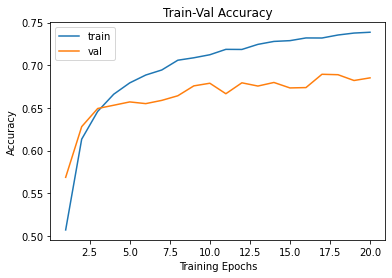

In [38]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

Teacher model 학습

In [39]:
# check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher = plane10().to(device)
x = torch.randn(3,3,32,32).to(device)
output = teacher(x)
print(output.shape)

torch.Size([3, 10])


가중치 초기화

In [40]:
teacher.apply(initialize_weights);

In [41]:
# optimizer
opt = optim.Adam(teacher.parameters())

하이퍼 파라미터 정의

In [42]:
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'val_dl':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [43]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/19, current lr= 0.001
Copied best model weights!
train loss: 0.009946, val loss: 0.011840, accuracy: 51.04, time: 0.7860 min
----------
Epoch 1/19, current lr= 0.001
Copied best model weights!
train loss: 0.006291, val loss: 0.008258, accuracy: 65.50, time: 1.5693 min
----------
Epoch 2/19, current lr= 0.001
Copied best model weights!
train loss: 0.004832, val loss: 0.005182, accuracy: 77.80, time: 2.3553 min
----------
Epoch 3/19, current lr= 0.001
Copied best model weights!
train loss: 0.003976, val loss: 0.005048, accuracy: 78.55, time: 3.1416 min
----------
Epoch 4/19, current lr= 0.001
train loss: 0.003339, val loss: 0.005129, accuracy: 78.22, time: 3.9293 min
----------
Epoch 5/19, current lr= 0.001
train loss: 0.002824, val loss: 0.005472, accuracy: 78.14, time: 4.7266 min
----------
Epoch 6/19, current lr= 0.001
Copied best model weights!
train loss: 0.002309, val loss: 0.004803, accuracy: 80.85, time: 5.5111 min
----------
Epoch 7/19, current lr= 0.001
Copied best mode

Loss 와 Accuracy의 시각화

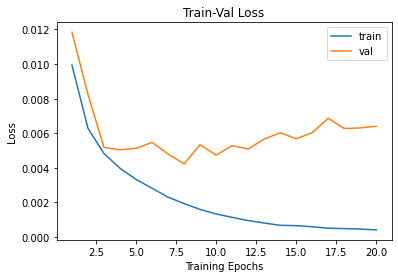

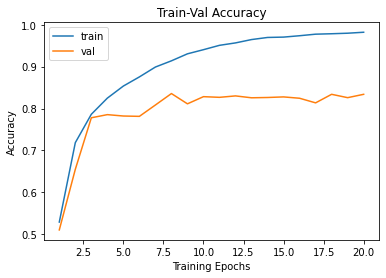

In [44]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

Student Model 학습.

In [45]:
# check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
student = plane2().to(device)
x = torch.randn(3,3,32,32).to(device)
output = teacher(x)
print(output.shape)

torch.Size([3, 10])


가중치 초기화

In [46]:
student.apply(initialize_weights);

Teacher 학습을 통해 얻은 Weight값들을 load

In [47]:
teacher = plane10().to(device)
# load weight
teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))
student = plane2().to(device)

# optimizer
opt = optim.Adam(student.parameters())

KD함수 선언 및 적용

In [48]:
# knowledge distillation loss
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

In [49]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

20epoch로 학습결과 비교

In [50]:
num_epochs= 20

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(trainloader.dataset)

    for xb, yb in trainloader:
        xb = xb.to(device)
        yb = yb.to(device)

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, testloader)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/19, current lr= 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


train loss: 0.013140, val loss: 0.009795, accuracy: 57.88, time: 0.5331 min
----------
Epoch 1/19, current lr= 0.001
train loss: 0.010084, val loss: 0.008807, accuracy: 62.37, time: 1.0560 min
----------
Epoch 2/19, current lr= 0.001
train loss: 0.009241, val loss: 0.008492, accuracy: 63.68, time: 1.5829 min
----------
Epoch 3/19, current lr= 0.001
train loss: 0.008770, val loss: 0.008147, accuracy: 64.69, time: 2.1083 min
----------
Epoch 4/19, current lr= 0.001
train loss: 0.008487, val loss: 0.008098, accuracy: 65.48, time: 2.6427 min
----------
Epoch 5/19, current lr= 0.001
train loss: 0.008259, val loss: 0.008158, accuracy: 65.75, time: 3.1777 min
----------
Epoch 6/19, current lr= 0.001
train loss: 0.008095, val loss: 0.007888, accuracy: 66.11, time: 3.7166 min
----------
Epoch 7/19, current lr= 0.001
train loss: 0.007943, val loss: 0.008193, accuracy: 65.46, time: 4.2496 min
----------
Epoch 8/19, current lr= 0.001
train loss: 0.007827, val loss: 0.007826, accuracy: 66.82, time:

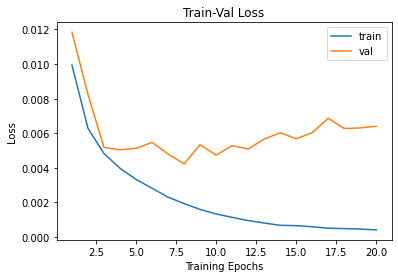

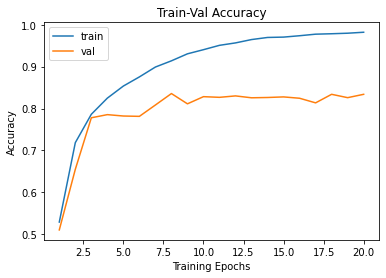

In [51]:
num_epochs = params_train['num_epochs']
# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()